In [1]:
using Revise

In [ ]:
include("eom.jl")

Main.Solvers

# AppDev

In [34]:

using DifferentialEquations
using .GoldbergerWiseEoM.EoMs
import .GoldbergerWiseEoM.Consts: yₘ, k, M_IR, γ²₀, u
using .GoldbergerWiseEoM.AffliatedFunctions: ϕ0, A, A′
using .GoldbergerWiseEoM.BCs

# # EoM of φ, obtained from the zero solution of the Einstein eq #(3.12)
function getφ(solF::ODESolution, params) 
    l², k, γ², m²= params
    F(y::Number)  = solF(y)[2]
    F′(y::Number) = solF(y)[1]
    φ(y::Number)  = -3ϕP^2/(2u*l²*ϕ0(y)) * (F′(y) - 2A′(y, l², k, γ²)*F(y))  #(3.12)
    return φ
end
function eom!(ddf, df, f, params, y)
    F  = f[1]
    F′ = df[1]
    dF′ = -P(y,params)*F′ -Q(y,params)*F#(3.17)
    ddf[1]=dF′
end
function solveODE(FP, params)
    yspan = (0.0,yₘ)
    F′P= dFP(FP, params)
    prob = SecondOrderODEProblem(eom!,[F′P], [FP],yspan, params)
    # return solve(prob, Tsit5())
    return solve(prob, ImplicitEuler())
    # return solve(prob, Rosenbrock23())
end
function errBCwithφ(params; FP = 1.)
    Fsol = solveODE(FP, params)
    FT′,FT = Fsol(yₘ)
    return Δφ′T(FT, FT′, params)
end

errBCwithφ (generic function with 1 method)

In [32]:
function paramsearch(;l2=nothing, g2=nothing, FP = 1., φP = 1., k=37u)
    if !isnothing(g2) && isnothing(l2)
        function paramsearch_l2_m2(l2, m2)
            params = (l2, k, g2, m2)
            return errBCwithφ(params , FP = FP)
        end
        return paramsearch_l2_m2
    elseif isnothing(g2) && !isnothing(l2)
        function paramserch_g2_m2(g2, m2)
            params = (l2, k, g2, m2)
            return errBCwithφ(params, FP = FP)
        end
        return paramserch_g2_m2
    end
end

paramsearch (generic function with 1 method)

In [49]:
include("LazyMatrices.jl")
include("TurtleSearch.jl")
import .LazyMatrices as lm
import .TurtleSearch as tt

In [50]:
using Plots, LaTeXStrings

In [51]:
function nextpose(poses, m)
    t = tt.Turtles(max(poses...))
    inds = tt.bisearch(t, m)
    xs = [m.xaxis(inds[1])]
    ys = [m.yaxis(inds[2])]
    while !isnothing(tt.next!(t, m))
        inds = tt.bisearch(t, m)
        push!(xs,m.xaxis(inds[1]))
        push!(ys,m.yaxis(inds[2]))
    end
    poses = tt.findfirstseed!(m, map(x->x+CartesianIndex(0,1), poses)...)
    return xs, ys, poses
end

nextpose (generic function with 1 method)

In [166]:
function g2_m2_numerical(l2, xrange, yrange, u=u, k=k; ylogscaled = true, nSeeds = 1, resol=20)
    paramsearch_g2_m2 = paramsearch(l2=l2)
    m = lm.LazyMatrix(zeros(resol,resol), paramsearch_g2_m2, xrange, yrange, ylogscaled = ylogscaled)
    poses = tt.findfirstseed!(m, CartesianIndex(resol, 1), CartesianIndex(resol, 2))
    g2_m2 = []
    for i = 1:nSeeds
        @assert !isnothing(poses) "$i-th seed not found"
        g2s, m2s, poses = nextpose(poses, m)
        push!(g2_m2, (g2s, m2s))
    end
    return g2_m2
end

g2_m2_numerical (generic function with 4 methods)

In [108]:
function g2_m2_perturb(l2, xrange, u=u, k=k, yₘ=yₘ)
    g2s0 = exp10.(range(xrange..., 100))
    m2s0 = 4l2*(2k+u)*u^2/(3k)*(1-exp(2k*yₘ))/(1-exp((4k+2u)*yₘ)) * (1 .- (4k+2u) ./g2s0)
    return g2s0, m2s0
end

g2_m2_perturb (generic function with 4 methods)

# shooting

In [170]:
xrange = log10.((1e-2γ²₀, 1e3γ²₀))
xrange0= log10.((1.5γ²₀, 1e3γ²₀))
yrange = log10.((1e-18M_IR^2, 1e5M_IR^2))
g2_m2 = g2_m2_numerical(1e-3, xrange, yrange, ylogscaled=true, nSeeds=2);

# visualisation

In [65]:
using GLMakie

In [171]:
seed_no = 2
g2s, m2s = g2_m2[seed_no]./(γ²₀, M_IR^2)
g2s0, m2s0 = g2_m2_perturb(1e-3, xrange0)./(γ²₀, M_IR^2);

In [173]:
g2_m2[seed_no]

([15000.000000000004], [2.869043303651876e-8])

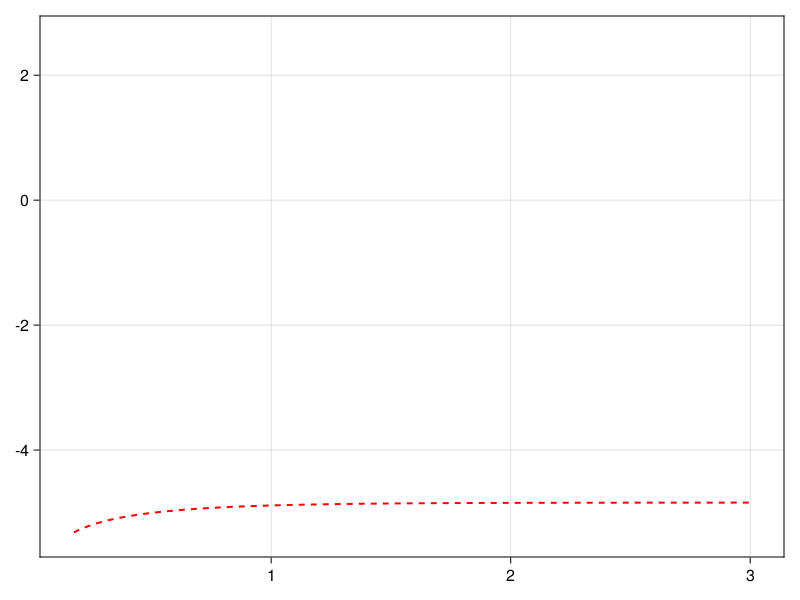

In [172]:
f, ax, l = lines(g2s .|> log10, m2s .|> log10, color=:blue, linewidth=2, linestyle=:dash, markersize=0, label="numerical")
lines!(ax, g2s0 .|> log10, m2s0 .|> log10, color=:red, linewidth=2, linestyle=:dash, markersize=0, label="perturbative")
f

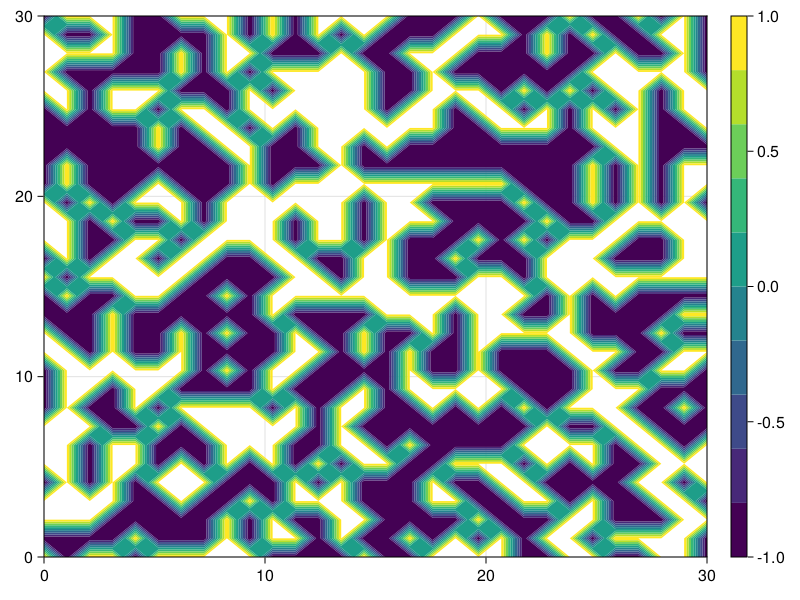

CairoMakie.Screen{IMAGE}


In [153]:
using CairoMakie
n=1
params = (1e-3, k, g2s[n], m2s[n])
m = fill(NaN,(30,30))
scl = range(9.9e-1, 1.01, 30)
for i in eachindex(scl), j in eachindex(scl)
    scale = (1,1,scl[i],scl[j])
    m[i,j] = errBCwithφ(params.*scale)
end
m = sign.(m)#.*(1 .- exp.(-abs.(m)))


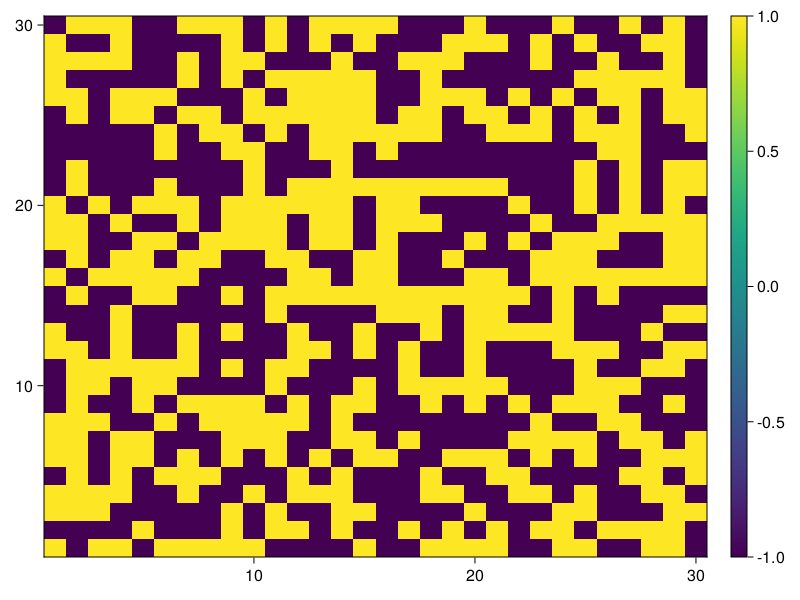

CairoMakie.Screen{IMAGE}


In [156]:
f = Figure()
ax = Axis(f[1, 1])
co = CairoMakie.heatmap!(m)
Colorbar(f[1, 2], co)
display(f)


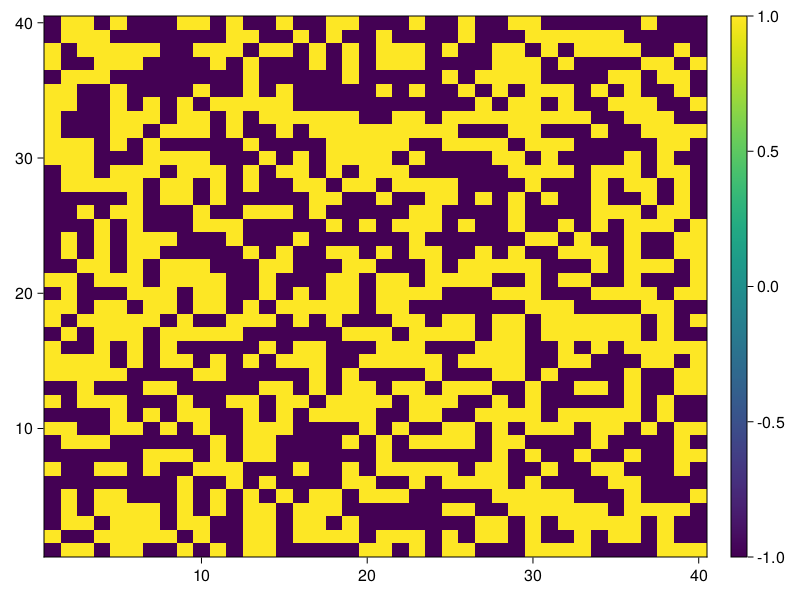

CairoMakie.Screen{IMAGE}


In [157]:
using CairoMakie
n=2
resol = 40
params = (1e-3, k, g2s[n], m2s[n])
m = fill(NaN,(resol,resol))
scl = range(9.9e-1, 1.01, resol)
for i in eachindex(scl), j in eachindex(scl)
    scale = (1,1,scl[i],scl[j])
    m[i,j] = errBCwithφ(params.*scale)
end
m = sign.(m)#.*(1 .- exp.(-abs.(m)))
f = Figure()
ax = Axis(f[1, 1])
co = CairoMakie.heatmap!(m)
Colorbar(f[1, 2], co)
display(f)

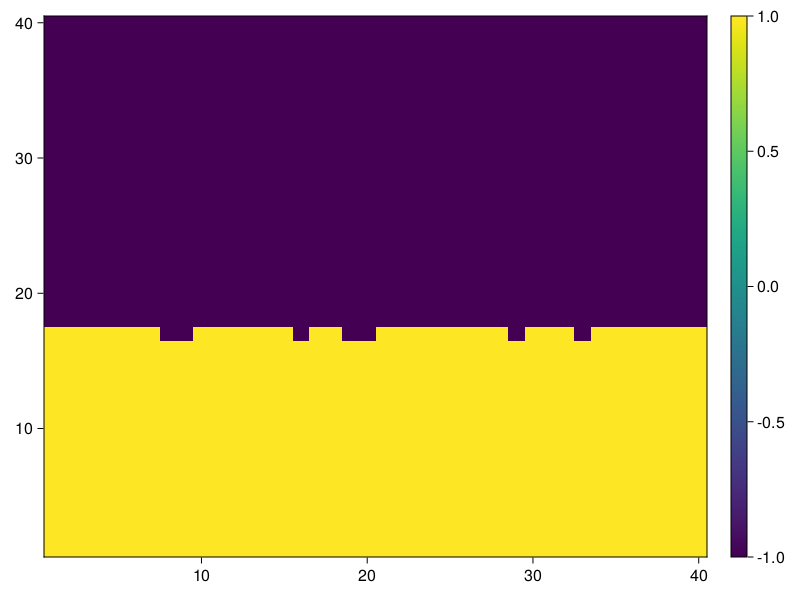

CairoMakie.Screen{IMAGE}


In [159]:
using CairoMakie
n=10
resol = 40
params = (1e-3, k, g2s[n], m2s[n])
m = fill(NaN,(resol,resol))
scl = range(9.9e-1, 1.01, resol)
for i in eachindex(scl), j in eachindex(scl)
    scale = (1,1,scl[i],scl[j])
    m[i,j] = errBCwithφ(params.*scale)
end
m = sign.(m)#.*(1 .- exp.(-abs.(m)))
f = Figure()
ax = Axis(f[1, 1])
co = CairoMakie.heatmap!(m)
Colorbar(f[1, 2], co)
display(f)

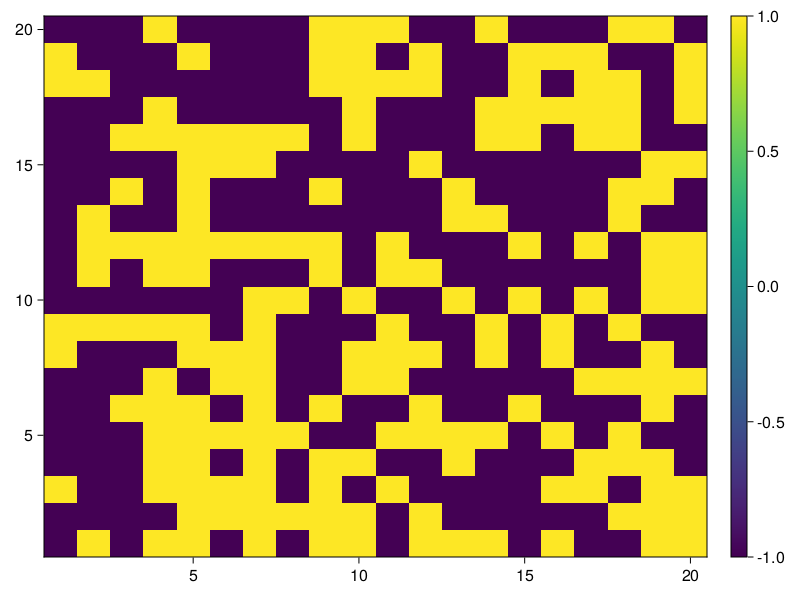

CairoMakie.Screen{IMAGE}


In [178]:
using CairoMakie
n=1
resol = 20
params = (1e-3, k, g2s[n], m2s[n])
m = fill(NaN,(resol,resol))
scl = range(1e-1, 2, resol)
for i in eachindex(scl), j in eachindex(scl)
    scale = (1,1,scl[i],scl[j])
    m[i,j] = errBCwithφ(params.*scale)
end
m = sign.(m)#.*(1 .- exp.(-abs.(m)))
f = Figure()
ax = Axis(f[1, 1])
co = CairoMakie.heatmap!(m)
Colorbar(f[1, 2], co)
display(f)

# Tests

In [54]:
g2_m2 = g2_m2_numerical(1., 0.1:0.1:10., 0.1:0.1:10., ylogscaled = true, nSeeds = 1)

1-element Vector{Any}:
 ([1.2589254117941673, 14.391480340317317, 1.2589254117941673], [128.7844066117013, 199.52623149688807, 1425.6204162488925])

In [45]:
f1 = paramsearch(l2=1e-1)
f2 = paramsearch(g2=1e-1)

(::var"#paramsearch_l2_m2#19"{Float64, Float64, Float64}) (generic function with 1 method)

In [ ]:
using .GoldbergerWiseEoM.BCs
FP = 1.0
params = (1.0, 1.0, 1.0, 1.0)  # You may need to adjust these values
    # Test the solveODE function
sol = solveODE(FP, params)
Δφ′T(FP, sol(yₘ)[1], params)

68.96856747818345

In [ ]:
using Test
using .GoldbergerWiseEoM.BCs
using DifferentialEquations
# using LinearAlgebra: norm

@testset "Test solveODE function" begin
    # Define some test parameters
    FP = 1.0
    params = (1.0, 1.0, 1.0, 1.0)  # You may need to adjust these values
    # Test the solveODE function
    sol = solveODE(FP, params)
    # println( sol(yₘ))
    Δφ′T(FP, sol(yₘ)[1], params)
    errBCwithφ(params)

    # Check that the solution is a valid DifferentialEquations solution
    @test isa(sol, DifferentialEquations.ODESolution)
    

    # Check that the solution satisfies the boundary conditions
    # You may need to adjust these tests based on your specific boundary conditions
end

Test.DefaultTestSet("Test solveODE function", Any[], 1, false, false, true, 1.704372527410951e9, 1.70437252744382e9)

In [13]:
using Test

@testset "Test Consts module" begin
using .GoldbergerWiseEoM.Consts
    @test yₘ == 1e0π
    @test u == 1.0e-1
    @test ϕP == 1.e-1
    @test ϕT == exp(-u * yₘ)*ϕP
    @test k == 37u
    @test M_IR == exp(-k*yₘ)
    @test γ²₀ == 4k+2u
end


Test Summary:      | Pass  Total  Time
Test Consts module |    7      7  0.0s


Test.DefaultTestSet("Test Consts module", Any[], 7, false, false, true, 1.704359214394436e9, 1.70435921442188e9)

In [16]:

@testset "Test AffliatedFunctions module" begin
using .GoldbergerWiseEoM.AffliatedFunctions
    # You may need to adjust these value
    l² = 1.0 
    y = 1.0 
    φ = 1.0 
    κ = 1.0 
    ϕ = 1.0 

    @test ϕ0(y) == ϕP * (ϕT/ϕP)^(y/yₘ)
    @test A(y, l², k, γ²₀) == k * y + l²/6 * (ϕT/ϕP)^(2y/yₘ)
    @test A′(y, l², k, γ²₀) == k + l²/6 * (ϕT/ϕP)^(2y/yₘ)* (-2u)
    @test A′′(y, l², k, γ²₀) == l²/6 * (ϕT/ϕP)^(2y/yₘ)* 4u^2
    @test λP′(φ, l², k, γ²₀) == -2u * (ϕP + φ)
    @test λT′(φ, l², k, γ²₀) == 2u * (ϕT + φ)
    @test λP′′(φ, l², k, γ²₀) == 2γ²₀
    @test λT′′(φ, l², k, γ²₀) == 2γ²₀
    @test W(ϕ, κ, k, u) == 6k/κ^2  - u*ϕ^2
    @test W′(ϕ, κ, k, u) == - 2u*ϕ
    @test V(W, ϕ, κ, k, u) == 1/8 * (W′(ϕ, κ, k, u))^2 - κ^2 / 6 * W(ϕ, κ, k, u)^2
end


Test Summary:                  | Pass  Total  Time
Test AffliatedFunctions module |   11     11  0.0s


Test.DefaultTestSet("Test AffliatedFunctions module", Any[], 11, false, false, true, 1.704359289091334e9, 1.704359289101345e9)

In [2]:
using Test
@testset "Test EoMs module" begin
using .GoldbergerWiseEoM.EoMs
    l² = 1.0 # You may need to adjust this value
    y = 1.0 # You may need to adjust this value
    m² = 1.0 # You may need to adjust this value
    k = 1.
    γ²₀ = 1.
    params = (l², k, γ²₀, m²)

    @show P(y, l², k, γ²₀, m²) 
    @show Q(y, l², k, γ²₀, m²) 
    @show RR(params)
    @show SS(params)
end

P(y, l², k, γ²₀, m²) = -1.7454179497948012
Q(y, l², k, γ²₀, m²) = 9.296694920112756
RR(params) = -0.009999999999999988
SS(params) = 

-64.19132447180202


Test Summary:    |Time
Test EoMs module | None  0.1s


Test.DefaultTestSet("Test EoMs module", Any[], 0, false, false, true, 1.704370431046375e9, 1.704370431171003e9)

In [3]:
using Test
@testset "BCs test" begin
using .GoldbergerWiseEoM.BCs
    l² = 1.e2 # You may need to adjust this value
    k = 1.0 
    γ²₀ = 1.0e-2 
    m² = 1e-1
    FP = 1.0 
    F = 1.0
    FF= 1.0
    params = (l², k, γ²₀, m²)

    @show dφT(F, FF, params)
    @show dFP(F, l², k, γ²₀, m²)
    @show dFP(F, params)
    @show Δφ′T(F, FF, params)
end

dφT(F, FF, params) = -0.014083017295517995
dFP(F, l², k, γ²₀, m²) = 3.041210628569292e14
dFP(F, params) = 3.041210628569292e14
Δφ′T(F, FF, params) = 2.8299831196116436e8


Test Summary: |Time
BCs test      | None  0.1s


Test.DefaultTestSet("BCs test", Any[], 0, false, false, true, 1.704370725915171e9, 1.70437072603553e9)

In [58]:
methods(GoldbergerWiseEoM.BCs.dFP)

# 1 method for generic function "dFP":
[1] dFP(FP, l², k, γ², m²) in Main.GoldbergerWiseEoM.BCs at /Users/outk/Documents/Codes/Julia/ModuliSpaces.jl/example/GoldbergerWise/eom.jl:89